In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall

# Load and preprocess the data 
data = pd.read_csv('resampled_dataset.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode the target variable 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Create an intermediate complexity MLP model
model = Sequential([
    Dense(256, activation='relu', input_shape=(9,), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(182, activation='softmax')
])

# Compile the model 
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Define callbacks for training 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.0084 - loss: 5.7170 - val_accuracy: 0.0137 - val_loss: 5.4412 - learning_rate: 0.0010
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0217 - loss: 5.2823 - val_accuracy: 0.0092 - val_loss: 5.3921 - learning_rate: 0.0010
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0351 - loss: 4.9881 - val_accuracy: 0.0137 - val_loss: 5.3021 - learning_rate: 0.0010
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0619 - loss: 4.6959 - val_accuracy: 0.0183 - val_loss: 5.1887 - learning_rate: 0.0010
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0719 - loss: 4.4696 - val_accuracy: 0.0160 - val_loss: 5.0315 - learning_rate: 0.0010
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0859 - loss: 4.3408 - val_accuracy: 0.0206 - val_loss: 4.8423 - learning_rate: 0.0010
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1037 - loss: 4.1385 - val_ac

### Explain parameters for the code above and why i use these values : 

* Normalize the input data - Κανονικοποιήση

RGB values are typically in the range 0-255. Normalizing them to 0-1 can help the model learn more effectively. Πιο συγκεκριμένα η κανονικοποίηση μπορεί να βοηθήσει το μοντέλο να μάθει πιο γρήγορα, καθώς οι αλγόριθμοι βελτιστοποίησης (όπως η gradient descent) λειτουργούν πιο αποτελεσματικά όταν τα δεδομένα είναι κανονικοποιημένα.H κανονικοποίηση μπορεί να οδηγήσει σε καλύτερη απόδοση του μοντέλου, καθώς βοηθά στην αποφυγή προβλημάτων όπως το "vanishing gradient" (εξαφάνιση κλίσης) ή το "exploding gradient" (έκρηξη κλίσης).Πολλά νευρωνικά δίκτυα χρησιμοποιούν συναρτήσεις ενεργοποίησης όπως η SIGMOID ή tanh, οι οποίες έχουν σχεδιαστεί για να λειτουργούν καλύτερα με εισόδους μεταξύ 0 και 1.

- Encode the target value - Κωδικοποιήση 

Machine learning models, especially neural networks, work with numbers, not text. Encoding transforms these text labels into a numerical format the model can understand and process. For multi-class problems, encoded labels allow the use of appropriate loss functions like categorical cross-entropy.

- MLP Model overall structure 

1. Activation Functions:

- ReLU: 

Η ReLU εισάγει μη γραμμικότητα στο δίκτυο, επιτρέποντάς του να μαθαίνει σύνθετα μοτίβα. Σε αντίθεση με το sigmoid ή το tanh, η ReLU δεν συνθλίβει τις κλίσεις στη θετική περιοχή, επιτρέποντας καλύτερη ροή κλίσης. Η ReLU είναι απλή στον υπολογισμό, γεγονός που επιταχύνει την εκπαίδευση.

- Softmax:  

Η κατάλληλη επιλογή για προβλήματα ταξινόμησης πολλαπλών κλάσεων, καθώς μετατρέπει τις εξόδους του μοντέλου σε πιθανότητες για κάθε κλάση.


2. Regularization Techniques:

- L2 Regularization (0.01): 

Discourages the model from relying too heavily on any single feature. It's like telling the model "don't put all your eggs in one basket". Βοηθά στην αποφυγή υπερβολικής προσαρμογής . Η τιμή 0.001 είναι απλά συνήθης

- Dropout (0.4): 

Το Dropout είναι μια τεχνική κανονικοποίησης που απενεργοποιεί τυχαία ένα ποσοστό των νευρώνων κατά την εκπαίδευση. Αυτό βοηθά στην αποφυγή της υπερβολικής προσαρμογής, αναγκάζοντας το μοντέλο να μάθει πιο γενικευμένα χαρακτηριστικά. Η τιμή 0.4 σημαίνει ότι το 40% των νευρώνων θα απενεργοποιούνται τυχαία σε κάθε βήμα εκπαίδευσης.

- BatchNormalization: 

Είναι κι αυτό μια τεχνική κανονικοποιήσης που κανονικοποιεί τις ενεργοποιήσεις των νευρώνων σε κάθε παρτίδα δεδομενων . Βοηθά στην σταθεροποιήση της εκπαίδευσης και επιταγχύνει τη σύγκλιση και μπορεί να βελτιώσει την απόδοση του μοντέλου .

3. Optimizer (Adam) and Learning Rate (0.001):

- Adam is like a smart teacher that adjusts how big of learning steps to take.

- 0.001 is a common starting point - not too fast, not too slow.


4. Loss Function (Categorical Cross-Entropy):

- This measures how wrong the model's predictions are. It's particularly good for problems with multiple classes like this one.


5. Training Parameters:

- Batch size (32): Processes 32 samples at a time. It's a balance between speed and memory use. This can herlp stabliize the learning process.

- Epochs (300): Maximum number of times to go through the entire dataset.

- Validation split (0.2): Uses 20% of data to check how well the model is learning.


6. Callbacks:

- ReduceLROnPlateau: 

Μειώνει αυτόματα τον learning rate όταν η απόδοση του μοντέλου στο validation set σταματά να βελτιώνεται. Αυτό μπορεί να βοηθήσει στην αποφυγή υπερβολικής προσαρμογής και στην επίτευξη καλύτερης απόδοσης.

- EarlyStopping: 

Σταματά την εκπαίδευση όταν η απόδοση στο validation set σταματά να βελτιώνεται για ένα ορισμένο αριθμό εποχών (epochs). Αυτό βοηθά στην αποφυγή υπερβολικής προσαρμογής και στην εξοικονόμηση χρόνου εκπαίδευσης.

7. Metrics: 
Because I'm dealing with imbalanced dataset it's better to use more metrisc because accuracy alone can be misleading !

## Train MLP model for the 'x6perfect_reseampled.csv' 

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall

# Load and preprocess the data (same as before)
data = pd.read_csv('x6perfect_reseampled.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode the target variable 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the data -  consider using stratified splitting to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, stratify=y, random_state=42)

# Create an intermediate complexity MLP model
model = Sequential([
    Dense(256, activation='relu', input_shape=(9,), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(182, activation='softmax')
])

# Compile the model 
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Define callbacks for training 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)


# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.0216 - loss: 5.4008 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.0233 - val_loss: 4.9052 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0966 - loss: 4.1523 - precision_1: 0.8950 - recall_1: 6.6617e-04 - val_accuracy: 0.2383 - val_loss: 3.4650 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1644 - loss: 3.4959 - precision_1: 0.6122 - recall_1: 0.0033 - val_accuracy: 0.3340 - val_loss: 2.8162 - val_precision_1: 0.8542 - val_recall_1: 0.0168 - learning_rate: 0.0010
Epoch 4/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2094 - loss: 3.1394 - precision_1: 0.6319 - recall_1: 0.0106 - val_accuracy: 0.3201 - val_loss: 2.6375 - val_precision_1: 0.9407 - val_recall_1: 0.0519 - learning_rate: 0.0010


#### Another form updated MLP model again for the 'x6perfect_reseampled.csv'

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0180 - loss: 5.4154 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0127 - val_loss: 4.9290 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0936 - loss: 4.1696 - precision: 0.7081 - recall: 9.0028e-04 - val_accuracy: 0.2371 - val_loss: 3.4873 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1451 - loss: 3.5543 - precision: 0.6215 - recall: 0.0041 - val_accuracy: 0.2976 - val_loss: 2.8908 - val_precision: 0.7742 - val_recall: 0.0098 - learning_rate: 0.0010
Epoch 4/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2051 - loss: 3.1867 - precision: 0.6015 - recall: 0.0127 - val_accuracy: 0.3765 - val_loss: 2.5704 - val_precision: 0.8659 - val_recall: 0.0290 - learning_rate: 0.0010
Epoch 5/300
306/306 ━━━━━━━━━━━

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.78      0.82      0.80        17
           1       0.90      0.53      0.67        17
           2       0.63      1.00      0.77        17
           3       0.65      0.76      0.70        17
           4       0.62      0.47      0.53        17
           5       0.27      0.53      0.36        17
           6       0.77      0.59      0.67        17
           7       0.33      0.53      0.41        17
           8       0.94      1.00      0.97        17
           9       0.93      0.81      0.87        16
          10       0.50      1.00      0.67        17
          11       0.50      0.76      0.60        17
          12       0.67      0.94      0.78        17
          13       0.59      1.00      0.74        17
          14       0.78      0.41      0.54        17
          15       0.79      0.69      0.73        16
          16       0.42      0.62      0.50        16
          17       0.67    

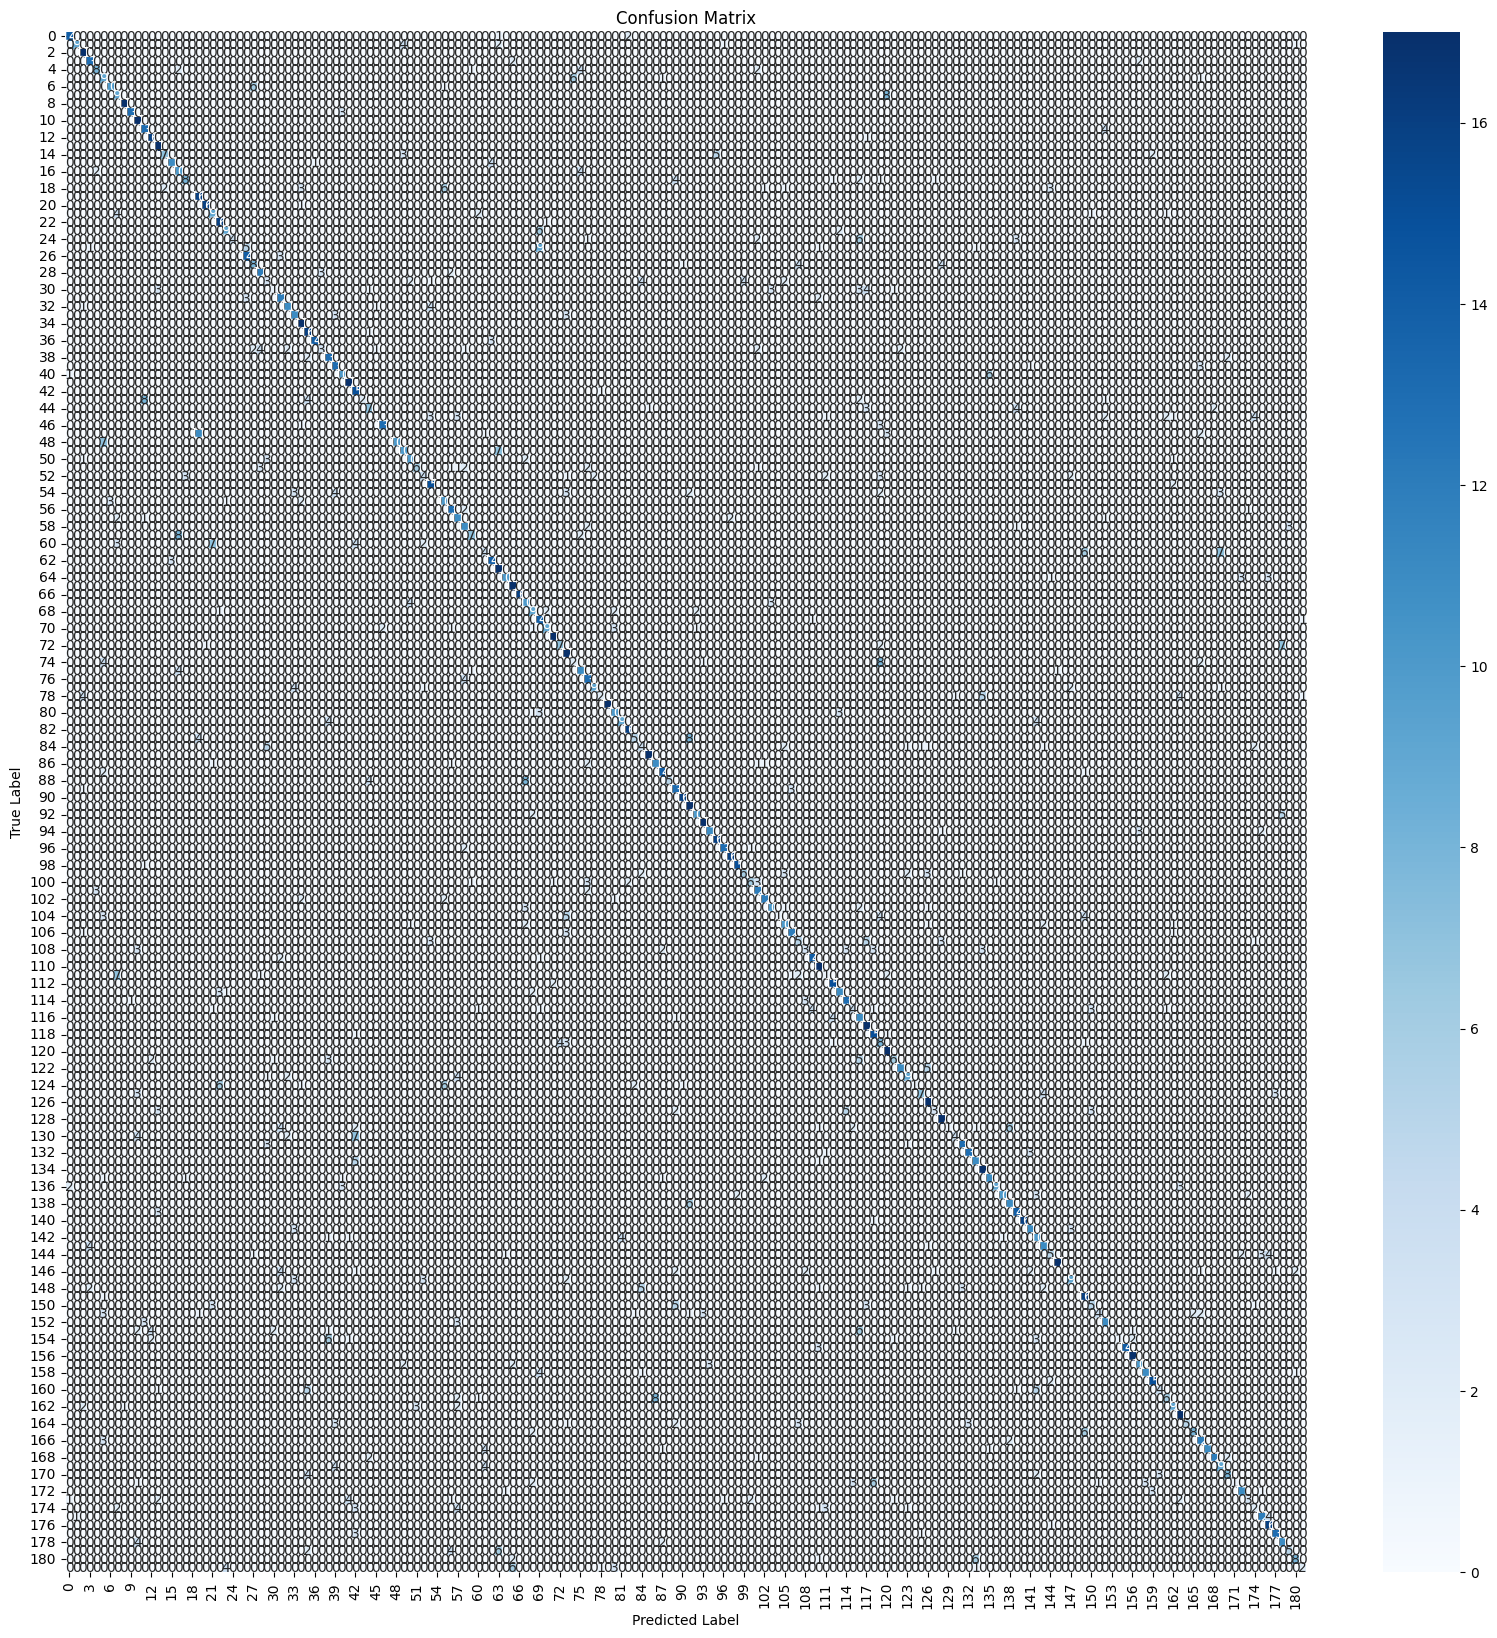

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
data = pd.read_csv('x6perfect_reseampled.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the data using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))

# Create an intermediate complexity MLP model
model = Sequential([
    Dense(256, activation='relu', input_shape=(9,), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(182, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Define callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 10))

lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping, lr_scheduler],
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred_classes))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()